# Feature Engineering 실습

: Data Source : https://www.kaggle.com/c/titanic <br>


---
#### 변수들 설명
+ PassngerId : Passenger Id <br>
+ Survived : 1=생존, 0=사망 <br>
+ PClass : 승객의 사회 경제적 지위를 표현 (1 = upper, 2 = middle, 3 = lower) <br>
+ SibSp : 동행한 sibling , spouse 수 <br>
+ Parch : 동행한 parents , children 수 <br>
+ Ticket : ticket number <br>
+ Cabin : cabin number <br>
+ Embarked : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
---

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
#!pip install pandas_profiling
#!pip install pandas_profiling --user

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

dir = '/content/drive/MyDrive/titanic.csv'
titanic = pd.read_csv(dir)
print(titanic.shape)
titanic.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#!pip install --upgrade pandas_profiling

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
pandas_profiling.ProfileReport(titanic)

##  Missing values
#### Missing data mechnisms

1. Missing Completely at Random (MCAR)
<br>
-the probability of being missing is the same for all the observations
<br>
-no relationship between the data missing and any other values
<br>
<br>
2. Missing at Random (MAR)
<br>
-the probabilty an observation being missing depends only on available information
<br>
-For example, if men are more likely to disclose their weight than women, weight is MAR. The weight information will be missing at random for those men and women that decided not to disclose their weight, but as men are more prone to disclose it, there will be more missing values for women than for men.
<br>
<br>
3. Missing Not at Random (MNAR)
<br>
-there is a mechanism or a reason why missing values are introduced in the dataset

In [ ]:
# 결측치 확인
# titanic.isnull() : DataFrame 형식으로 보여짐
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
(titanic.isnull().sum()/len(titanic)*100).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

<b>[ex1]</b> Age에 있는 NULL값 177개가 생존('Survived'=1), 사망('Survived'=0)에 각각 몇 개씩 있는지 알고 싶다면?

In [ ]:
# 1. Age column의 null 여부를 나타내는 'age_null' column을 새롭게 만들기
# np.where() 사용
titanic['age_null'] = np.where(titanic.Age.isnull(),1,0) # null이면 1, 아니면 0
print(titanic.shape)
titanic.head()

(891, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_null
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [ ]:
# 2. [ex1]에서 원하는 결과값이 나오도록 코딩하기
# groupby 사용
# titanic.groupby('Survived')[['age_null']].sum() : DataFrame 형태로 나옴
titanic.groupby('Survived')['age_null'].sum()

Survived
0    125
1     52
Name: age_null, dtype: int64

## NA Imputation 
###  Numeric Variable

#### 공통적인 전제
- 타깃값 또는 다른 변수와의 관계성을 살펴보아야 함.

---
### (1) Deletion (Complete Case Analysis)

- NA 값을 버리는 방법 : NA 가 없는 변수를 살펴보기.
- categorical 과 numerical variable 모두에 사용가능한 방법. <br>
<br>

#### Assumption

- MCAR 일 때 효과가 좋음.

#### advantage :)

- 쉬움.
- 변수의 분포가 보존. (데이터가 MCAR 이라면 그럴것이라고 생각됨)

#### disadvantage :(

- 의미있는 데이터를 잃을 수도 있음.
- 사실 추천하는 방법은 아님. 주로 NA 값이 매우 적을 때 사용. 물론 여기서 NA 값의 갯수에 대한 기준은 없음.
---

In [ ]:
# (1) Deletion
titanic_age = pd.read_csv(dir, usecols = ['Age', 'Fare', 'Survived'])
print(titanic_age.shape)
titanic_age.isnull().sum()

(891, 3)


Survived      0
Age         177
Fare          0
dtype: int64

In [ ]:
# 결측치가 있는 Row 날리기
titanic_age_droprow = titanic_age.dropna()
print(titanic_age_droprow.shape)
titanic_age_droprow.head()

(714, 3)


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [ ]:
# 결측치가 있는 Column 지우기 : 이 때, 위의 코드에서 axis='columns' 옵션만 추가하기
titanic_age_dropcol= titanic_age.dropna(axis='columns')
print(titanic_age_dropcol.shape)
titanic_age_dropcol.head()

(891, 2)


,Survived,Fare
0,0,7.2500
1,1,71.2833
2,1,7.9250
3,1,53.1000
4,0,8.0500


<b>[ex2]</b> 이번에는 'Age'말고 titanic의 'Cabin'을 불러와서 위의 방식과 같이 지워보기

In [ ]:
titanic_cabin = pd.read_csv(dir, usecols = ['Cabin', 'Fare', 'Survived'])
print(titanic_cabin.shape)
titanic_cabin.isnull().sum()

(891, 3)


Survived      0
Fare          0
Cabin       687
dtype: int64

In [ ]:
titanic_cabin_droprow = titanic_cabin.dropna()
print(titanic_cabin_droprow.shape)
titanic_cabin_droprow.head()

(204, 3)


,Survived,Fare,Cabin
1,1,71.2833,C85
3,1,53.1000,C123
6,0,51.8625,E46
10,1,16.7000,G6
11,1,26.5500,C103


In [ ]:
titanic_cabin_dropcol= titanic_cabin.dropna(axis='columns')
print(titanic_cabin_dropcol.shape)
titanic_cabin_dropcol.head()

(891, 2)


,Survived,Fare
0,0,7.2500
1,1,71.2833
2,1,7.9250
3,1,53.1000
4,0,8.0500


---
### (2) Mean and Median imputation
<br>
#### Assumption
- MCAR

#### Advantage
- 쉽고 빠름.

#### Limitation
- original variance를 변형시킬 수 있음.
- 다른 변수와 공분산을 변형시킬 수 있음 = 다른 변수와의 관계가 변형될 수 있음

#### Imputation important
- overfitting을 피하기 위해 train set에서 imputate 할 값을 정하고 이를 train set과 test set 모두에 적용.
---

In [ ]:
titanic_age.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(titanic_age[['Age','Fare']], 
                                                    titanic_age.Survived, 
                                                    test_size=0.3,
                                                    random_state=0)

print("training predictors size:", X_train.shape) 
print("training response size:", y_train.shape)    
print("test predictors size:", X_test.shape)      
print("test response size:", y_test.shape)

training predictors size: (623, 2)
training response size: (623,)
test predictors size: (268, 2)
test response size: (268,)


In [ ]:
# Age의 median, mean 확인
[X_train.Age.median(), X_train.Age.mean()]

[29.0, 29.915338645418327]

In [ ]:
# 'Age_median', 'Age_mean' column 생성
titanic_age['Age_median'] = titanic_age.Age.fillna(X_train.Age.median())
titanic_age['Age_mean'] = titanic_age.Age.fillna(X_train.Age.mean())

In [ ]:
titanic_age.isnull().sum()

Survived        0
Age           177
Fare            0
Age_median      0
Age_mean        0
dtype: int64

In [ ]:
titanic_age.head()

,Survived,Age,Fare,Age_median,Age_mean
0,0,22.0,7.2500,22.0,22.0
1,1,38.0,71.2833,38.0,38.0
2,1,26.0,7.9250,26.0,26.0
3,1,35.0,53.1000,35.0,35.0
4,0,35.0,8.0500,35.0,35.0


In [ ]:
titanic_age.head(6)

,Survived,Age,Fare,Age_median,Age_mean
0,0,22.0,7.2500,22.0,22.000000
1,1,38.0,71.2833,38.0,38.000000
2,1,26.0,7.9250,26.0,26.000000
3,1,35.0,53.1000,35.0,35.000000
4,0,35.0,8.0500,35.0,35.000000
5,0,NaN,8.4583,29.0,29.915339


In [ ]:
# Vaciance가 달라졌음을 알 수 있음
print('Original Variance: ', titanic_age['Age'].std())
print('Variance after median imputation: ', titanic_age['Age_median'].std())
print('Variance after mean imputation: ', titanic_age['Age_mean'].std())

Original Variance:  14.526497332334044
Variance after median imputation:  13.005010341761817
Variance after mean imputation:  13.00230174541604


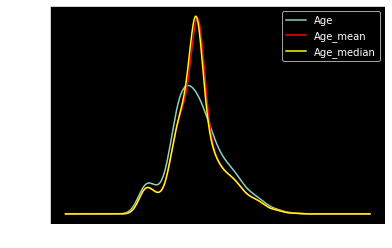

In [ ]:
# Variance 시각화
fig = plt.figure()
plt.style.use(['dark_background'])
ax = fig.add_subplot(111)
titanic_age['Age'].plot(kind='kde',ax=ax)
titanic_age['Age_mean'].plot(kind='kde', ax=ax, color='red')
titanic_age['Age_median'].plot(kind='kde', ax=ax, color='yellow')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

---
### (3) Random sample imputation

- mean/median을 imputation하는 것과 비슷. 
- 하지만 원래 변수의 분포를 유지하기위한 목적을 갖고 있다는 점에서 차이를 보임. <br><br>

#### Assumption
- MCAR 인 상황을 가정.
- 분산이 유지될 것.

#### Advantage
- 쉬움.
- 분산과 분포가 유지 됨. (물론 아닌 경우도 있음. random이니까)
- 하지만 비지니스적인 분야에서 유용한 경우도 있다고 함.

#### Limitation
- Randomness
- Risky
---

In [ ]:
# 'Age' column을 하나 복사해서 새로운 column 'Age_filled' 만들기
titanic_age['Age_filled'] = titanic_age['Age']
titanic_age.head(6)

,Survived,Age,Fare,Age_median,Age_mean,Age_filled
0,0,22.0,7.2500,22.0,22.000000,22.0
1,1,38.0,71.2833,38.0,38.000000,38.0
2,1,26.0,7.9250,26.0,26.000000,26.0
3,1,35.0,53.1000,35.0,35.000000,35.0
4,0,35.0,8.0500,35.0,35.000000,35.0
5,0,NaN,8.4583,29.0,29.915339,NaN


In [ ]:
# (( 표본집단 )).sample( 뽑고자 하는 샘플 개수 ) 
temp = (titanic_age['Age'].dropna().sample(titanic_age['Age'].isnull().sum()))

# sampling 한 temp에 index 부여하기
temp.index = titanic_age[lambda x: x.Age.isnull()].index
titanic_age.loc[titanic_age['Age'].isnull(), 'Age_filled'] = temp

In [ ]:
print(titanic_age.isnull().sum())
titanic_age[['Age','Age_filled']].head(6)

Survived        0
Age           177
Fare            0
Age_median      0
Age_mean        0
Age_filled      0
dtype: int64


,Age,Age_filled
0,22.0,22.0
1,38.0,38.0
2,26.0,26.0
3,35.0,35.0
4,35.0,35.0
5,NaN,36.0


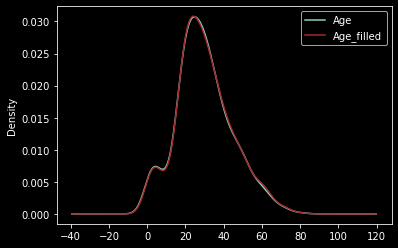

In [ ]:
# Variance 시각화
fig = plt.figure()
ax = fig.add_subplot(111)
titanic_age['Age'].plot(kind='kde', ax=ax)
titanic_age['Age_filled'].plot(kind='kde', ax=ax, color='brown')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### 그렇다면 mean/median vs random ??
- NA가 missing completely at random ?
- 변수의 분포를 유지하고 싶은가 ?
- randomness를 인정할 것인가 ?
- data competition? make business driven dicisions?

---
### (4) Adding a variable to capture NA
- 위에서 MCAR 일 때 NA값을 채우는 2가지 방법에 대해 배움.
<br> <br>

- <b>But</b>, 만약 NA값이 completely at random이 아니라면? <br>
새로운 변수를 만듬으로써 missingness의 정보성을 유지할 수 있음. <br><br>

#### 추가되는 변수
- NA인 데이터는 1, NA가 아닌 데이터는 0을 할당.

#### Advantage
- 쉽고 NA값의 정보성을 유지.

#### Disadvantage
- 차원이 늘어남.
- 새로 만든 변수가 비슷한 경우 등 생각할 거리가 늘어남.
---

<b>[ex3]</b> na인 행은 1, 아닌 행은 0을 나타내는 새 column 'Age_NA' 생성하기

In [ ]:
# np.where() 사용
titanic_age['Age_NA']= np.where(titanic.Age.isnull(),1,0)
titanic_age[['Age','Age_NA']].head(10)

,Age,Age_NA
0,22.0,0
1,38.0,0
2,26.0,0
3,35.0,0
4,35.0,0
5,NaN,1
6,54.0,0
7,2.0,0
8,27.0,0
9,14.0,0


#  categorical variable

---
### (1) Frequent category imputation
<br>
#### Assumption
- MCAR 일 때, 가장 빈도수가 높은 값으로 채움.

#### Advantage
- 쉬움.

#### Limitation
- 원래 변수의 모습을 바꿀 수 있음.
- NA의 수가 많다면 빈도수가 높은 값이 over-representation 될 수 있음.
---

In [ ]:
cols_to_use = ['Sex', 'Embarked',  'Survived']

titanic_cat = pd.read_csv(dir, usecols=cols_to_use)
titanic_cat.head()

,Survived,Sex,Embarked
0,0,male,S
1,1,female,C
2,1,female,S
3,1,female,S
4,0,male,S


<b>[ex4]</b> titanic_cat에는 몇 개의 NA가 있는지 확인하기

In [ ]:
titanic_cat.isnull().sum()

Survived    0
Sex         0
Embarked    2
dtype: int64

In [ ]:
# 'S'가 가장 많음
titanic_cat['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
# 결측값을 'S'로 채워줌
titanic_cat['Embarked_filled'] = titanic_cat.Embarked.fillna("S")

In [ ]:
titanic_cat.isnull().sum()

Survived           0
Sex                0
Embarked           2
Embarked_filled    0
dtype: int64

---
### (2) Adding a category to capture NA

- categoriacal 에서 가장 많이 쓰이는 방법. 
- NA값으로 'Missing' 이라는 새로운 카테고리를 만듦.
- 주로 NA의 수가 많을 때 사용. <br><br>

#### Advantage
- 쉬움.
- missingness를 잡을 수 있음.

#### Disadvatage
- NA의 수가 적다면 Tree계열 모델에서 overfitting을 일으킬 수도 있음.
---

In [ ]:
cols_to_use = ['Sex', 'Embarked',  'Survived']

titanic_cat2 = pd.read_csv(dir, usecols=cols_to_use)
titanic_cat2.head()

,Survived,Sex,Embarked
0,0,male,S
1,1,female,C
2,1,female,S
3,1,female,S
4,0,male,S


In [ ]:
# Embarked에서 NA값이라는 정보를 유지한 채 새로운 binary 형태 column 생성
titanic_cat2['Missing'] = np.where(titanic_cat.Embarked.isnull(),1,0)
titanic_cat2.isnull().sum()

Survived    0
Sex         0
Embarked    2
Missing     0
dtype: int64

---
##  Outliers
- outliers는 없애야 할까?
<br>
예를 들어, 신용카드 활동의 이상치는 fraudeulent한 활동의 sign일 수 있음. 그러므로 함부로 없애는 것이 아니라 잘 살펴보아야 함. 하지만 머신러닝 모델의 성능을 떨어트릴수 있기 때문에 다양한 방법으로 filter해주어야 함.
<br>
<br>
- outliers에 민감한 머신러닝 모델은?
<br>
몇몇 모델은 이상치에 민감.
<br>
1.adaboost : 결측치에 가중치를 많이 두게 되서 일반화성능이 떨어짐
<br>
2.Decision trees : 결측치에 별 상관없음
<br>
3.Linear model : 민감
<br>
4.Neural Networks : 민감
<br>
<br>
- outliers를 찾는 방법
<br>
<br>
    변수의 분포가 가우시안분포(정규분포)를 따른다면 mean +- 3*sd 
<br>
    그렇지 않다면 IQR = 75th quantile - 25th quantile

    Upper boundary = 75th quantile + (IQR * 1.5)

    Lower boundary = 25th quantile - (IQR * 1.5)

    or for extreme cases:

    Upper boundary = 75th quantile + (IQR * 3)

    Lower boundary = 25th quantile - (IQR * 3)
---

In [ ]:
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_null
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


Text(0, 0.5, 'Number of Passengers')

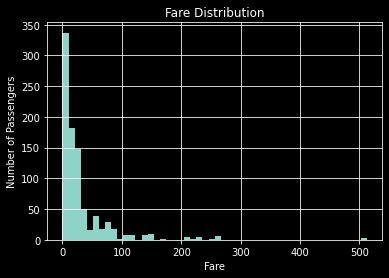

<Figure size 432x288 with 0 Axes>

In [ ]:
# histogram으로 Fare와 Number of Passengers 관계 나타내기
fig = titanic.Fare.hist(bins=50)
plt.figure()
fig.set_title('Fare Distribution')
fig.set_xlabel('Fare')
fig.set_ylabel('Number of Passengers')

In [ ]:
titanic.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [ ]:
print('total passengers: {}'.format(titanic.shape[0]))

print('passengers that paid more than 65: {}'.format(
    titanic[titanic.Fare > 65].shape[0]))

print('passengers that paid more than 100: {}'.format(
    titanic[titanic.Fare > 100].shape[0]))

total passengers: 891
passengers that paid more than 65: 116
passengers that paid more than 100: 53


In [ ]:
high_fare_df = titanic[titanic.Fare>100]
high_fare_df.shape

(53, 13)

In [ ]:
high_fare_df.groupby('Ticket')[['Fare']].count()

,Fare
Ticket,
113503,1
113760,4
113781,4
16966,2
17421,4
19950,4
24160,3
35273,3
36928,2


In [ ]:
titanic[titanic.Fare>300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_null
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,0
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,0
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,0


티켓 번호가 같은 사람들은 티켓을 같이 샀다고 생각할 수 있음. 그래서 개인 가격이 아니라 단체 가격이기 때문에 이상치가 생긴 것이라고 예상가능함. 따라서 이상치를 인원수대로 나누어 주면 됨.

---
## 5. Transformation
자주 하는 변수 변환들

---

#### Categories

보통 카테고리는 글자 그대로를 인풋으로 못받아주는 scikit-learn 모델들이 가끔 있기 때문에 여러 변환을 거쳐야 함.


In [ ]:
titanic_embarked = pd.read_csv(dir, usecols=['Embarked'])
titanic_embarked.head()

,Embarked
0,S
1,C
2,S
3,S
4,S


In [ ]:
titanic_embarked.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

---
### (1) 더미화 변환 : pd.get_dummies()
---

In [ ]:
pd.get_dummies(titanic_embarked).head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [ ]:
pd.get_dummies(titanic_embarked, dummy_na=True).head()

,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


회귀모델을 쓸 때는 원래 column을 빼야함. <br>
tree모델은 원래 column을 유지하는 것이 오히려 좋은 결과가 나옴.

---
### (2) Ordinal number encoding

순서가 있는 범주 순서에 따라 숫자 변수를 만드는 과정.

연속적인 정보를 담아줄 수 있기는 하지만, 단위에 문제가 생김.

6이 1의 6배라는 의미가 통하지 않기 때문.

---

In [ ]:
titanic_embarked['Embarked'] = titanic_embarked['Embarked'].map({'C':0,'Q':1,'S':2})
titanic_embarked.head()

,Embarked
0,2.0
1,0.0
2,2.0
3,2.0
4,2.0


sklearn.preprocessing.LabelEncoder()

#### 날짜 transformation

In [ ]:
import datetime

base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, 30)]
df = pd.DataFrame(date_list)
df.columns = ['day']
df

,day
0,2021-01-19 04:43:42.404386
1,2021-01-18 04:43:42.404386
2,2021-01-17 04:43:42.404386
3,2021-01-16 04:43:42.404386
4,2021-01-15 04:43:42.404386
5,2021-01-14 04:43:42.404386
6,2021-01-13 04:43:42.404386
7,2021-01-12 04:43:42.404386
8,2021-01-11 04:43:42.404386
9,2021-01-10 04:43:42.404386


In [ ]:
# Monday = 0
df['day_of_week'] = df['day'].dt.weekday
df.head()

,day,day_of_week
0,2021-01-19 04:43:42.404386,1
1,2021-01-18 04:43:42.404386,0
2,2021-01-17 04:43:42.404386,6
3,2021-01-16 04:43:42.404386,5
4,2021-01-15 04:43:42.404386,4


In [ ]:
df['day_of_week'] = df['day'].dt.day_name()
df.head()

,day,day_of_week
0,2021-01-19 04:43:42.404386,Tuesday
1,2021-01-18 04:43:42.404386,Monday
2,2021-01-17 04:43:42.404386,Sunday
3,2021-01-16 04:43:42.404386,Saturday
4,2021-01-15 04:43:42.404386,Friday


In [ ]:
weekday_map = {'Monday':1,
               'Tuesday':2,
               'Wednesday':3,
               'Thursday':4,
               'Friday':5,
               'Saturday':6,
               'Sunday':7
}

df['day_ordinal'] = df.day_of_week.map(weekday_map)
df.head(10)

,day,day_of_week,day_ordinal
0,2021-01-19 04:43:42.404386,Tuesday,2
1,2021-01-18 04:43:42.404386,Monday,1
2,2021-01-17 04:43:42.404386,Sunday,7
3,2021-01-16 04:43:42.404386,Saturday,6
4,2021-01-15 04:43:42.404386,Friday,5
5,2021-01-14 04:43:42.404386,Thursday,4
6,2021-01-13 04:43:42.404386,Wednesday,3
7,2021-01-12 04:43:42.404386,Tuesday,2
8,2021-01-11 04:43:42.404386,Monday,1
9,2021-01-10 04:43:42.404386,Sunday,7


## 6. Feature Scaling
### Variable magnitude

> Does the magnitude of the variable matter?
<br><br>
- Linear Regression 모델은 변수의 스케일이 중요. x값의 magnitude가 변하면 그에 해당하는 상관계수(coefficient)도 변함. 특히 여러가지 변수가 있을 때, range가 큰 변수는 작은 변수에 비해 더 큰 영향력을 미칠 수 있음. 
<br>
- Gradient descent 알고리즘은 변수들이 비슷한 스케일에 있을 때 속도가 빠름. 그러므로 feature scaling은 Neural Networks, Logistic Regression에서도 유용. SVM 모델에서 feature scaling은 support vectors를 찾는 시간을 줄여줌.
<br>
- 유클리디안이나 각종 거리를 측정하는 알고리즘을 사용하는 모델도 변수의 magnitude에 영향을 받음. 그러므로 feature scaling은 KNN이나 K-means clustering 같은 모델에서도 중요.
<br>

#### The machine learning models affected by the magnitude of the feature are:

- Linear and Logistic Regression
- Neural Networks
- Support Vector Machines
- KNN
- K-means clustering
- Linear Discriminant Analysis (LDA)
- Principal Component Analysis (PCA)

#### Machine learning models insensitive to feature magnitude are the ones based on Trees:

- Classification and Regression Trees
- Random Forests
- Gradient Boosted Trees


In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler # z = (x - x_mean) / std
from sklearn.preprocessing import MinMaxScaler   # X_scaled = (X - X.min / (X.max - X.min)
from sklearn.preprocessing import RobustScaler   # X_scaled = (X - X.median) / IQR

---
### 5-1. Standardization (표준화)
- 변수들을 비슷한 scale로 만들어 줌
- 변환 후 평균 = 0, 분산 = 1

$$z = \frac{x - \bar{x}}{s}$$

---

In [ ]:
data = pd.read_csv(dir, usecols = ['Pclass', 'Age', 'Fare', 'Survived'])
data.head()

,Survived,Pclass,Age,Fare
0,0,3,22.0,7.2500
1,1,1,38.0,71.2833
2,1,3,26.0,7.9250
3,1,1,35.0,53.1000
4,0,3,35.0,8.0500


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['Pclass', 'Age', 'Fare']],
                                                    data.Survived, 
                                                    test_size=0.3,
                                                    random_state=0)

print("training predictors size:", X_train.shape) 
print("training response size:", y_train.shape)    
print("test predictors size:", X_test.shape)      
print("test response size:", y_test.shape)

training predictors size: (623, 3)
training response size: (623,)
test predictors size: (268, 3)
test response size: (268,)


In [ ]:
# 'Age'의 결측값을 mean으로 채움
X_train['Age'] = X_train.Age.fillna(X_train.Age.mean())
X_test['Age'] = X_test.Age.fillna(X_train.Age.mean())

In [ ]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print('means (Pclass, Age and Fare): ', X_train_scaled.mean(axis=0))
print('std (Pclass, Age and Fare): ', X_train_scaled.std(axis=0))
print('Min values (Pclass, Age and Fare): ', X_train_scaled.min(axis=0))
print('Max values (Pclass, Age and Fare): ', X_train_scaled.max(axis=0))

means (Pclass, Age and Fare):  [ 4.98976640e-17 -2.85129509e-17  5.41746067e-17]
std (Pclass, Age and Fare):  [1. 1. 1.]
Min values (Pclass, Age and Fare):  [-1.5325562  -2.24804184 -0.67314402]
Max values (Pclass, Age and Fare):  [0.84844757 3.84992684 9.95192344]


In [ ]:
X_train_scaled

array([[-1.5325562 ,  1.62074379, -0.12253019],
       [-1.5325562 ,  1.46700702,  0.91812372],
       [ 0.84844757, -2.22267527,  0.29950338],
       ...,
       [ 0.84844757,  0.        , -0.51276504],
       [ 0.84844757,  0.46771807, -0.31228976],
       [-0.34205431,  2.31255922,  0.13566725]])

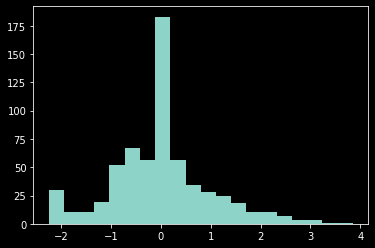

In [ ]:
# Age
plt.hist(X_train_scaled[:,1], bins=20)
plt.show()

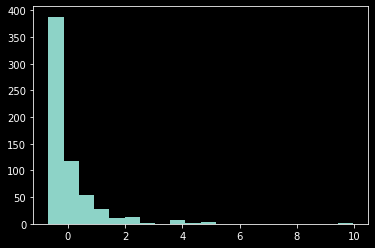

In [ ]:
# Fare
plt.hist(X_train_scaled[:,2], bins=20)
plt.show()

Age는 가우시안 분포의 모양이 되었지만 fare는 잘되지 않음. (Maybe due to outlier)

---
### 5-2. MinMaxScaler
모든 값들이 0과 1사이에 놓이도록 변형시켜줍니다. 표준화 (정규화)와 마찬가지로 아웃라이어에 취약해요.

$$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$

---

In [ ]:
scaler_minmax = MinMaxScaler() # 객체 생성
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train) #  fit the scaler to the train set
X_test_scaled_minmax = scaler_minmax.transform(X_test) # transform the test set

In [ ]:
print('평균 (Age, Fare):', X_train_scaled_minmax.mean(axis=0))
print('표준편차 (Age, Fare):', X_train_scaled_minmax.std(axis=0))
print('최솟값 (Age, Fare):', X_train_scaled_minmax.min(axis=0))
print('최댓값 (Age, Fare):', X_train_scaled_minmax.max(axis=0))

평균 (Age, Fare): [0.64365971 0.36865421 0.06335433]
표준편차 (Age, Fare): [0.41999093 0.16398904 0.09411705]
최솟값 (Age, Fare): [0. 0. 0.]
최댓값 (Age, Fare): [1. 1. 1.]


위에서 최솟값은 0, 최댓값은 1에 맞추어짐. 
하지만, 평균과 표준편차가 더이상 0과 1이 아님.

아래에서 원래 값과 비교

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


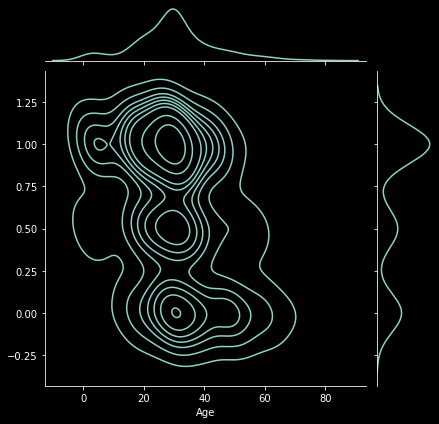

In [ ]:
sns.jointplot(X_train.Age, X_train_scaled_minmax[:,0], kind='kde');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


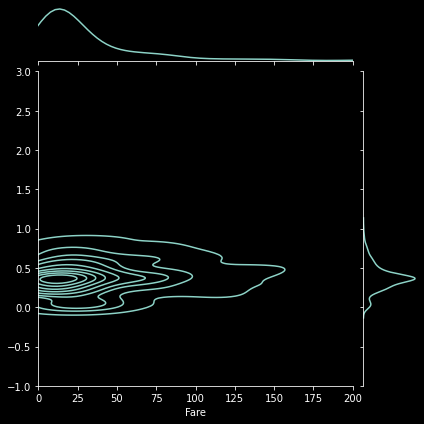

In [ ]:
sns.jointplot(X_train.Fare, X_train_scaled_minmax[:,1], kind='kde', xlim=(0,200), ylim=(-1,3));